{'DBpedia50k': 10890, 'FB15k': 59071, 'FB15k-237': 20466, 'WN18RR': 3134, 'WN18': 5000, 'YAGO3-10': 5000, 'Wikidata5M': 5133}
3828
{'DBpedia50k': [0.060453400503778336, 0.030226700251889168, 0.010075566750629723, 0.08816120906801007, 0.12090680100755667, 0.017632241813602016, 0.0025188916876574307], 'FB15k': [0.15678, 0.83938, 0.09274, 0.08478, 0.2886, 0.23394, 0.02904], 'FB15k-237': [0.005873966353008269, 0.0014827487881380096, 0.029883090960935273, 0.1532363843741089, 0.40809808953521526, 0.14810379241516966, 0.008782435129740519], 'WN18RR': [0.0, 0.0, 0.3704680290046144, 0.0, 0.0, 0.01120632827949901, 0.0], 'WN18': [0.0, 0.767, 0.2248, 0.0, 0.0084, 0.0068, 0.0], 'YAGO3-10': [0.6442, 0.0, 0.0044, 0.0622, 0.0718, 0.0, 0.0], 'Wikidata5M': [0.0, 0.02149912841371296, 0.029827619601007167, 0.03021499128413713, 0.05888049583575441, 0.0007747433662599264, 0.0]}


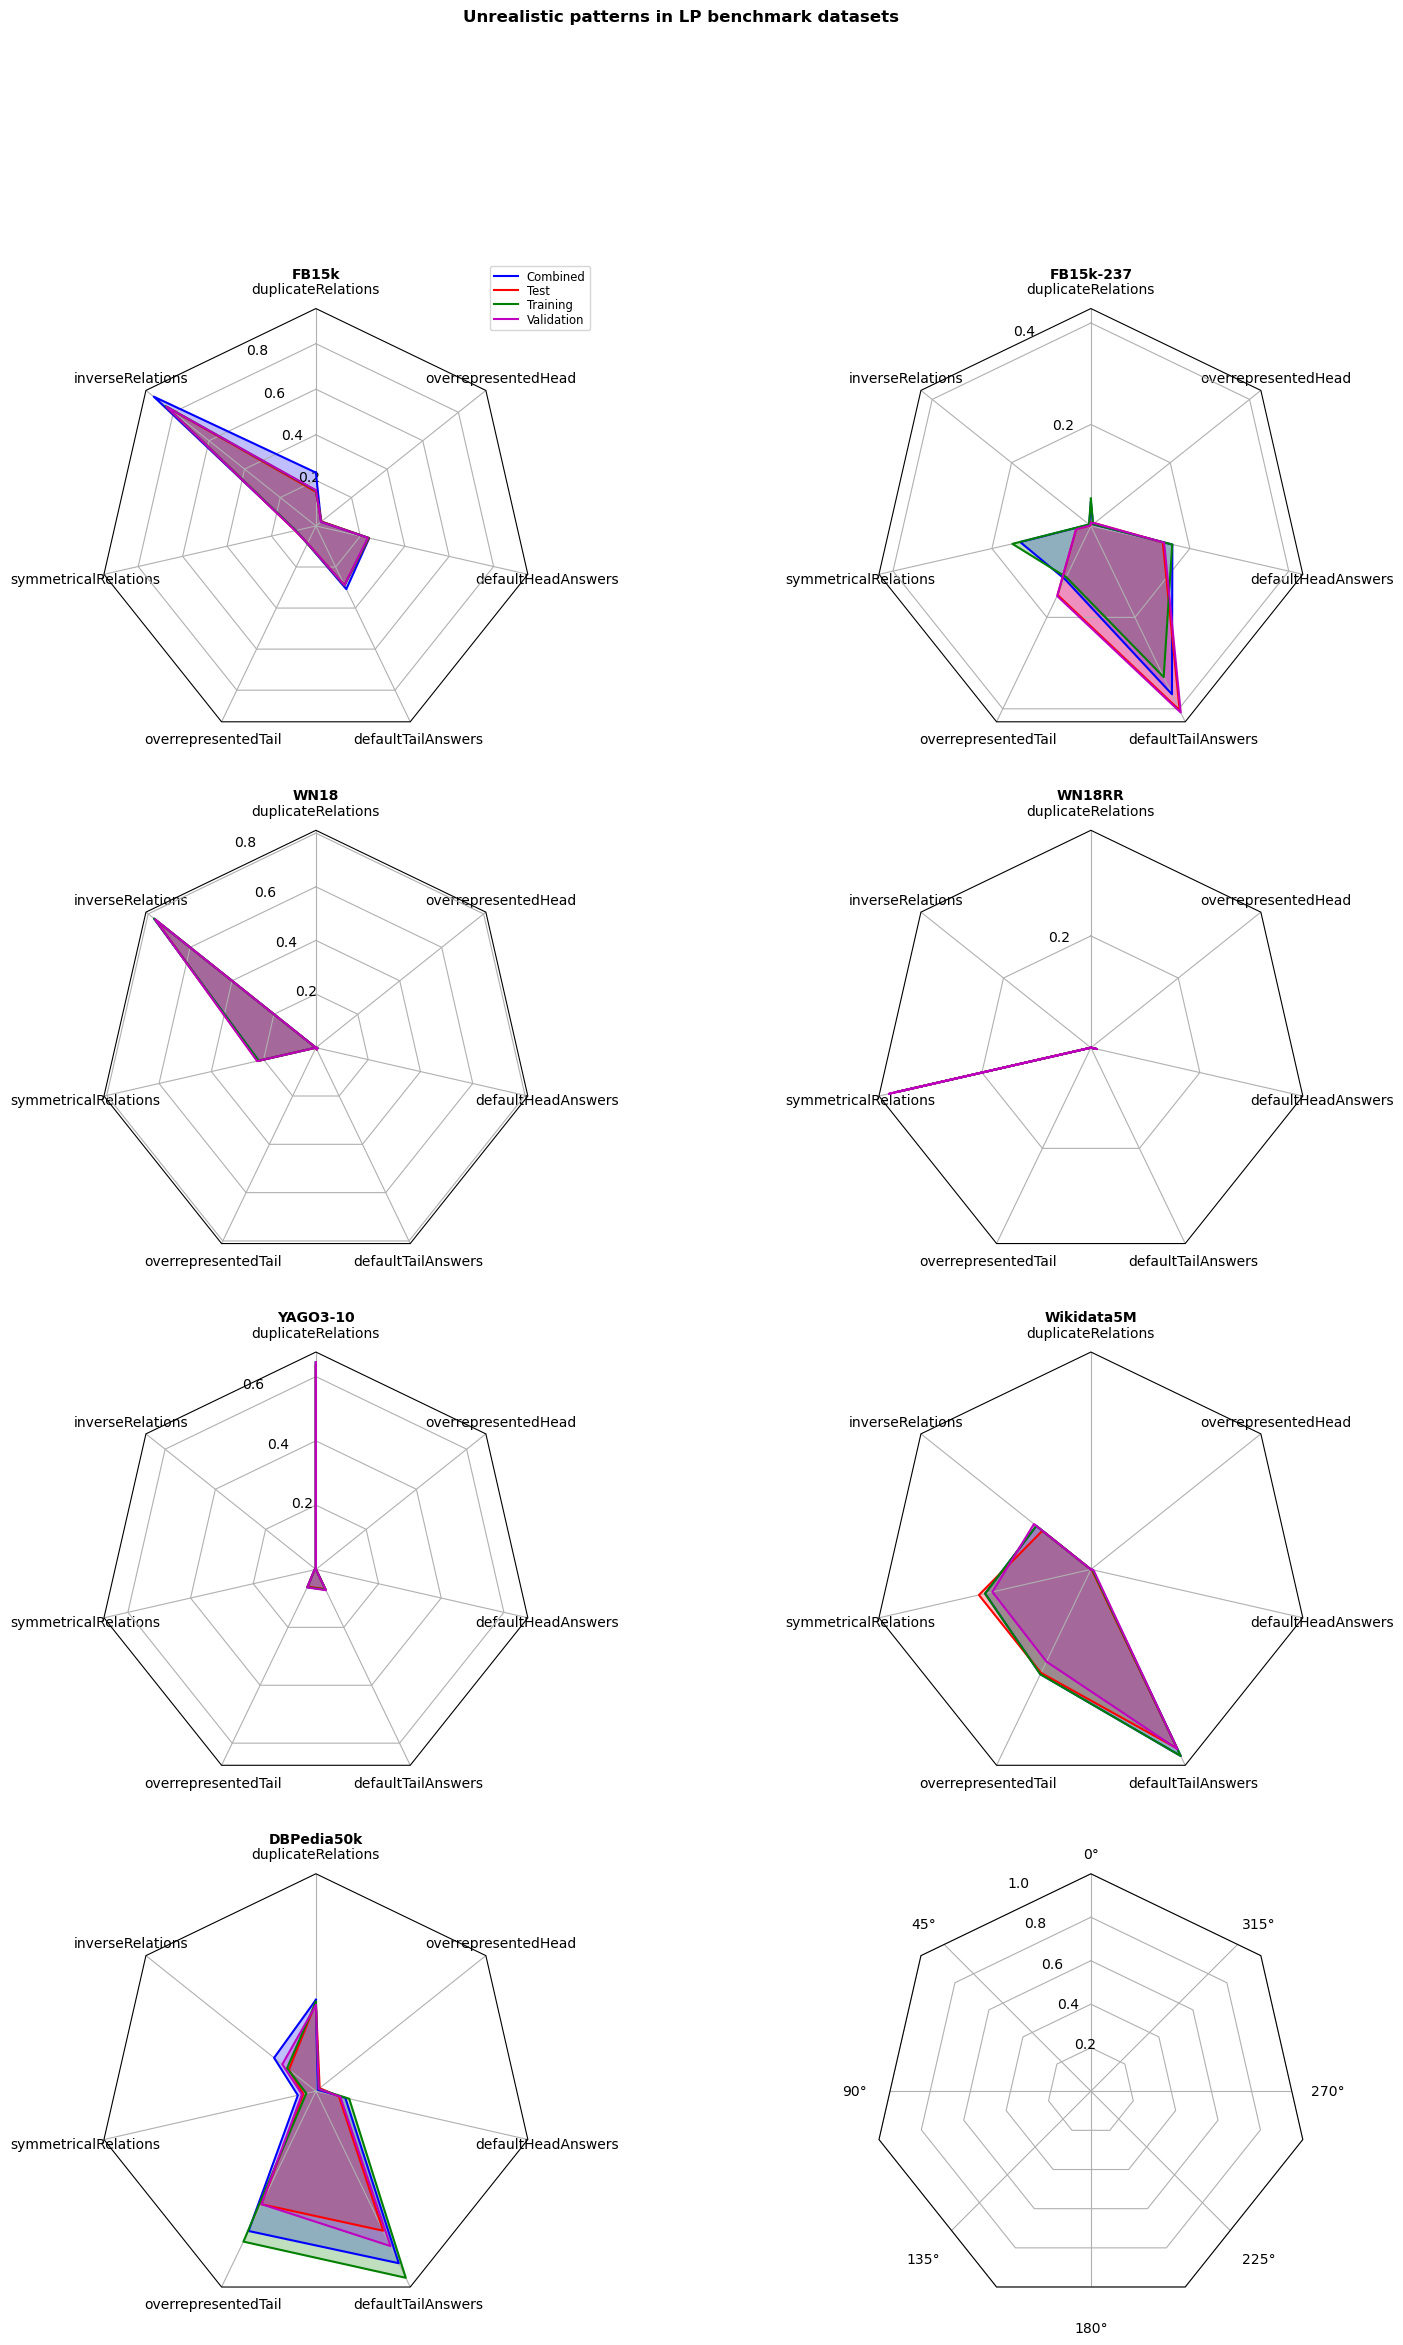

In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import pandas as pd


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def generate_plot_data():
    triple_stats = pd.read_csv(os.getcwd() + "/data/split_analysis/triples.csv")
    bias_stats = pd.read_csv(os.getcwd() + "/data/bias_affected_triples/combined.csv")
    bias_test_stats = pd.read_csv(os.getcwd() + "/data/bias_affected_triples/test.csv")
    bias_training_stats = pd.read_csv(os.getcwd() + "/data/bias_affected_triples/train.csv")
    bias_validation_stats = pd.read_csv(os.getcwd() + "/data/bias_affected_triples/validation.csv")
    datasets = triple_stats["dataset"].to_list()
    bias_types = list(bias_stats)[1:]
    dataset_triple_count = {dataset: triple_stats.loc[triple_stats['dataset'] == dataset]["tripleCountTotal"].values[0] for dataset in datasets}
    test_triple_count = {dataset: triple_stats.loc[triple_stats['dataset'] == dataset]["tripleCountTest"].values[0] for dataset in datasets}
    training_triple_count = {dataset: triple_stats.loc[triple_stats['dataset'] == dataset]["tripleCountTraining"].values[0] for dataset in datasets}
    validation_triple_count = {dataset: triple_stats.loc[triple_stats['dataset'] == dataset]["tripleCountValidation"].values[0] for dataset in datasets}

    biased_triples = {dataset: [bias_stats.loc[bias_stats['dataset'] == dataset][biasType].values[0]/dataset_triple_count[dataset] for biasType in bias_types] for dataset in datasets}
    biased_test_triples = {dataset: [bias_test_stats.loc[bias_test_stats['dataset'] == dataset][biasType].values[0]/test_triple_count[dataset] for biasType in bias_types] for dataset in datasets}
    biased_training_triples = {dataset: [bias_training_stats.loc[bias_training_stats['dataset'] == dataset][biasType].values[0]/training_triple_count[dataset] for biasType in bias_types] for dataset in datasets}
    biased_validation_triples = {dataset: [bias_validation_stats.loc[bias_validation_stats['dataset'] == dataset][biasType].values[0]/validation_triple_count[dataset] for biasType in bias_types] for dataset in datasets}
    
    data = [
        bias_types,
        ('FB15k', [
            biased_triples["FB15k"],
            biased_test_triples["FB15k"],
            biased_training_triples["FB15k"],
            biased_validation_triples["FB15k"],
            ]),
        ('FB15k-237', [
            biased_triples["FB15k-237"],
            biased_test_triples["FB15k-237"],
            biased_training_triples["FB15k-237"],
            biased_validation_triples["FB15k-237"],
            ]),
        ('WN18', [
            biased_triples["WN18"],
            biased_test_triples["WN18"],
            biased_training_triples["WN18"],
            biased_validation_triples["WN18"],
            ]),
        ('WN18RR', [
            biased_triples["WN18RR"],
            biased_test_triples["WN18RR"],
            biased_training_triples["WN18RR"],
            biased_validation_triples["WN18RR"],
            ]),
        ('YAGO3-10', [
            biased_triples["YAGO3-10"],
            biased_test_triples["YAGO3-10"],
            biased_training_triples["YAGO3-10"],
            biased_validation_triples["YAGO3-10"],
            ]),
            
        ('Wikidata5M', [
            biased_triples["Wikidata5M"],
            biased_test_triples["Wikidata5M"],
            biased_training_triples["Wikidata5M"],
            biased_validation_triples["Wikidata5M"],
            ]),
            
        ('DBPedia50k', [
            biased_triples["DBpedia50k"],
            biased_test_triples["DBpedia50k"],
            biased_training_triples["DBpedia50k"],
            biased_validation_triples["DBpedia50k"],
            ]),
            
    ]
    return data


if __name__ == '__main__':
    N = 7
    theta = radar_factory(N, frame='polygon')

    data = generate_plot_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(18, 25), nrows=4, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y', 'g', 'g']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Combined', 'Test', 'Training', 'Validation')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'Unrealistic patterns in LP benchmark datasets',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    plt.savefig("output/network_analysis/patterns.png", bbox_inches="tight")
    plt.show()
